# Background

Heart diseases are the leading cause of death globally. Each year, over a million deaths occur worldwide. One third of these deaths occur below the age of 70.  A lot of effort is provided by researchers all over the world to provide prevention, help, relieve, and hopefully one day cure heart diseases. 
People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.


# Introduction

This project is an analytical study to predict the risk of having a heart failure. Various data analysis techniques have been used to observe trends between various risk factors for heart diseases. Based on the features, different machine learning models were then implemented to predict whether a person has heart disease.


# Package Imports

In [23]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action='ignore')

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Data Loading 

In [24]:
df = pd.read_csv('heart-2.csv')

In [25]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Data Preprocessing

In [26]:
df["Sex"] = df["Sex"].astype('category')
df["Gender_cat"] = df["Sex"].cat.codes

df["ChestPainType"] = df["ChestPainType"].astype('category')
df["ChestPainType_cat"] = df["ChestPainType"].cat.codes

df["RestingECG"] = df["RestingECG"].astype('category')
df["RestingECG_cat"] = df["RestingECG"].cat.codes

df["ExerciseAngina"] = df["ExerciseAngina"].astype('category')
df["ExerciseAngina_cat"] = df["ExerciseAngina"].cat.codes

df["ST_Slope"] = df["ST_Slope"].astype('category')
df["ST_Slope_cat"] = df["ST_Slope"].cat.codes

In [27]:
df.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Gender_cat,ChestPainType_cat,RestingECG_cat,ExerciseAngina_cat,ST_Slope_cat
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,1,1,1,0,2
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0,2,1,0,1


In [28]:
df.drop(['Sex', 'ChestPainType','RestingECG','ExerciseAngina','ST_Slope'], axis=1, inplace=True)

In [29]:
df.rename(columns={'Gender_cat': 'Gender', 'ChestPainType_cat': 'ChestPainType','RestingECG_cat': 'RestingECG', 
                   'ExerciseAngina_cat': 'ExerciseAngina','ST_Slope_cat': 'ST_Slope'}, inplace=True)

In [30]:
df.head(2)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Gender,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,40,140,289,0,172,0.0,0,1,1,1,0,2
1,49,160,180,0,156,1.0,1,0,2,1,0,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   RestingBP       918 non-null    int64  
 2   Cholesterol     918 non-null    int64  
 3   FastingBS       918 non-null    int64  
 4   MaxHR           918 non-null    int64  
 5   Oldpeak         918 non-null    float64
 6   HeartDisease    918 non-null    int64  
 7   Gender          918 non-null    int8   
 8   ChestPainType   918 non-null    int8   
 9   RestingECG      918 non-null    int8   
 10  ExerciseAngina  918 non-null    int8   
 11  ST_Slope        918 non-null    int8   
dtypes: float64(1), int64(6), int8(5)
memory usage: 54.8 KB


In [32]:
df.isnull().sum()

Age               0
RestingBP         0
Cholesterol       0
FastingBS         0
MaxHR             0
Oldpeak           0
HeartDisease      0
Gender            0
ChestPainType     0
RestingECG        0
ExerciseAngina    0
ST_Slope          0
dtype: int64

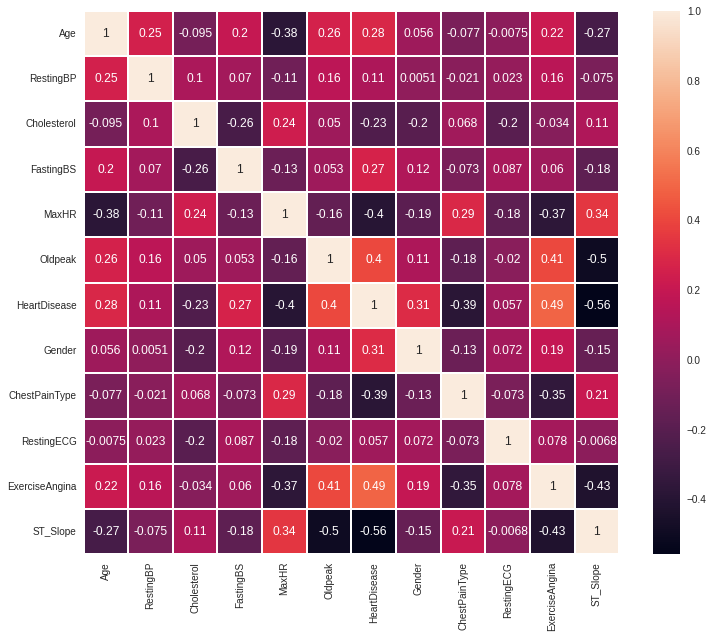

In [33]:
plt.figure(figsize = (12,10))
sns.heatmap(df.corr(), annot = True, linewidths = .2)
plt.show()

# Plotting Function

In [34]:
def plot_histgram(feature):    
    fig = px.histogram(df, x=feature,
                       color="HeartDisease", 
                       marginal="box",
                       barmode ="overlay",
                       histnorm ='density'
                      )  
    fig.update_layout(
        title_font_color="white",
        legend_title_font_color="yellow",
        title={
            'text': feature+" histogram",
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        paper_bgcolor="black",
        plot_bgcolor='black',
        font_color="white"
    )
    fig.show()

# EDA

#### Data proportion (presence of heart disease)

In [35]:
colors = ['gold', 'mediumturquoise']
labels = ['Normal','Heart Disease']
values = df['HeartDisease'].value_counts()/df['HeartDisease'].shape[0]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Heart Disease",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

#### Categories of chest pain

In [36]:
import plotly.graph_objects as go

night_colors = ['#F9B1B8',  '#EE4355',  '#B60618','#820815']
labels = [x for x in df.ChestPainType.value_counts().index]
values = df.ChestPainType.value_counts()


fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,pull=[0, 0, 0.06, 0])])

fig.update_layout(
    title_text="Chest pain type ")
fig.update_traces(marker=dict(colors=night_colors))
fig.show()

#### Blood Pressure, Cholestrol and Heart Rate range

In [37]:
import plotly.figure_factory as ff
from plotly.offline import iplot
# Add histogram data
x1 = df["RestingBP"]
x2 = df["Cholesterol"]
x3 = df["MaxHR"]

# Group data together
hist_data = [x1, x2, x3]

group_labels = ['RestingBP', 'Cholesterol', 'MaxHR']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=10,colors=night_colors)

fig.show()

#### Categorization of presence of heart disease based on chest pain type

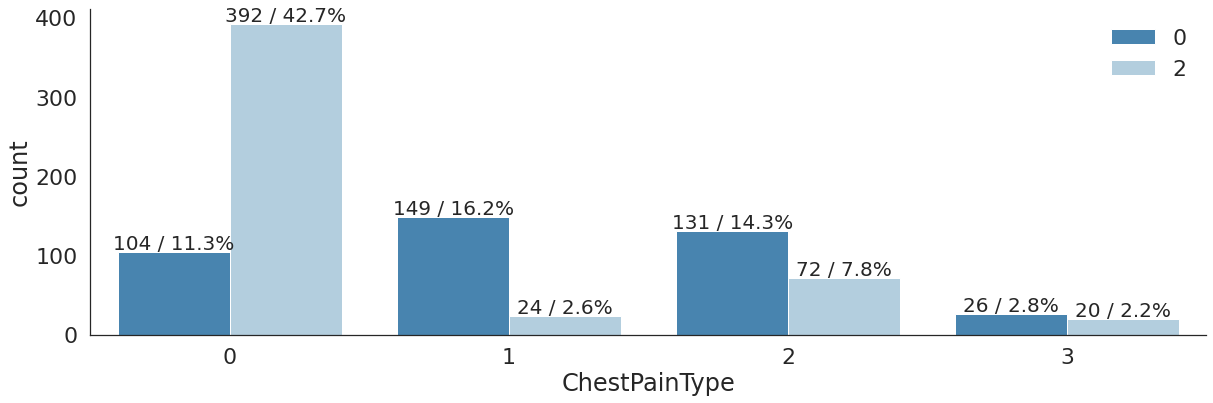

In [38]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(20,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=df, x='ChestPainType',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

#### Categorization of presence of heart disease based on ExerciseAngina

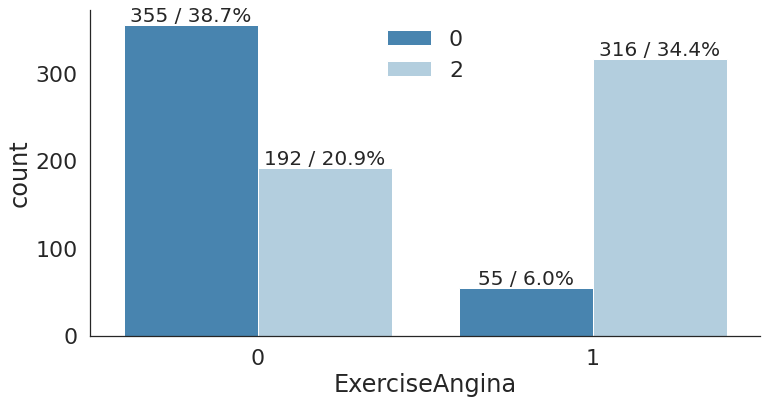

In [39]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(12,6))
sns.set(font_scale = 2)
sns.set_style("white")
ax = sns.countplot(data=df, x='ExerciseAngina',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 10, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()

Heart disease is often diagnosed when exercise-induced angina is present.

#### Categorization of presence of heart disease based on ST Slope

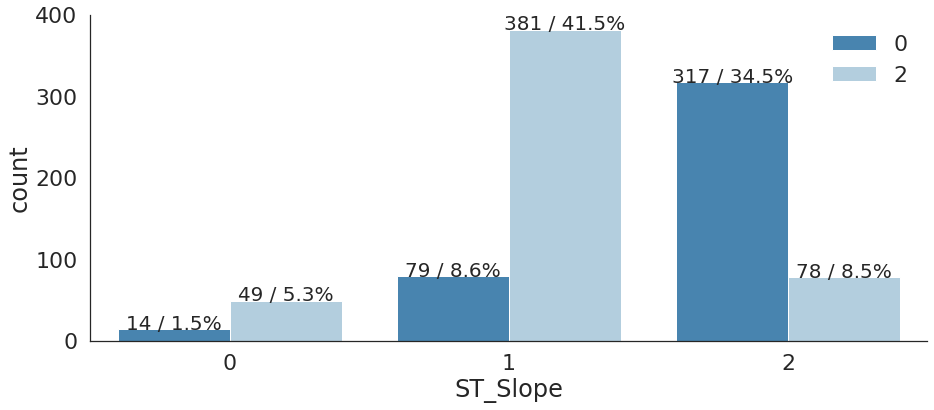

In [40]:
total_cnt = df['HeartDisease'].count()
plt.figure(figsize=(15,6))
sns.set(font_scale = 2)
plt.subplots_adjust(wspace=0.3)
sns.set_style("white")
ax = sns.countplot(data=df, x='ST_Slope',hue='HeartDisease',palette='Blues_r')
for p in ax.patches:
    x, height, width = p.get_x(), p.get_height(), p.get_width()
    ax.text(x + width / 2, height + 7, f'{height} / {height / total_cnt * 100:2.1f}%', va='center', ha='center', size=20)
plt.legend(labels=labels)
sns.despine()


When ST_Slope is Up, it is often judged as Normal.
If ST_Slope is flat/down, it is often judged as heart disease.

#### Categorization of presence of heart disease based on age range

In [41]:
def display_stat(feature):
    mean = df[feature].mean()
    std = df[feature].std()
    skew = df[feature].skew()
    kurtosis = df[feature].kurtosis()
    print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))

In [42]:
plot_histgram('Age')
display_stat('Age')

mean: 53.5109, std: 9.4326, skew: -0.1959, kurtosis: -0.3861 


#### Categorization of presence of heart disease based on Resting Blood Pressure

In [ ]:
plot_histgram('RestingBP')
display_stat('RestingBP')

mean: 132.3965, std: 18.5142, skew: 0.1798, kurtosis: 3.2713 


#### Categorization of presence of heart disease based on Cholestrol

In [ ]:
plot_histgram('Cholesterol')
display_stat('Cholesterol')

mean: 198.7996, std: 109.3841, skew: -0.6101, kurtosis: 0.1182 


#### Categorization of presence of heart disease based on Max Heart Rate

In [ ]:
plot_histgram('MaxHR')
display_stat('MaxHR')

mean: 136.8094, std: 25.4603, skew: -0.1444, kurtosis: -0.4482 


# Modeling

**Note : Once you run the two code snippets below, it will as you to restart runtime. After you restart runtime, run the code from beginning without running the below 2 snippets and directly jumping to run "from pycaret import"**

In [14]:
!pip install pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 25.8 MB/s 
     |████████████████████████████████| 10.4 MB 23.7 MB/s 
     |████████████████████████████████| 134 kB 76.2 MB/s 
     |████████████████████████████████| 167 kB 46.3 MB/s 
     |████████████████████████████████| 56 kB 5.4 MB/s 
     |████████████████████████████████| 262 kB 72.4 MB/s 
     |████████████████████████████████| 1.3 MB 66.6 MB/s 
     |████████████████████████████████| 6.8 MB 53.5 MB/s 
     |████████████████████████████████| 17.0 MB 65.0 MB/s 
     |████████████████████████████████| 88 kB 9.8 MB/s 
     |████████████████████████████████| 3.3 MB 64.8 MB/s 
     |████████████████████████████████| 1.7 MB 65.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████

In [15]:
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires markupsafe~=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


#### After restarting runtime, run the following code

In [43]:
from pycaret.classification import *

# Train Test Split

In [44]:
df_copy = df.copy()

In [45]:
import numpy as np
msk = np.random.rand(len(df_copy)) < 0.8
train_df = df_copy[msk]
test_df = df_copy[~msk]

In [46]:
X_train = train_df.drop('HeartDisease',axis=1)
y_train = train_df.pop('HeartDisease')

In [47]:
X_test = test_df.drop('HeartDisease',axis=1)
y_test = test_df.pop('HeartDisease')

In [48]:
all_cols = [cname for cname in X_train.columns]

# Training

In [49]:
setup(data = df, 
      target = 'HeartDisease',
      preprocess = False,
      numeric_features = all_cols,
      verbose = False,
      silent = True)

INFO:logs:PyCaret Supervised Module
INFO:logs:ML Usecase: classification
INFO:logs:version 2.3.10
INFO:logs:Initializing setup()
INFO:logs:setup(target=HeartDisease, ml_usecase=classification, available_plots={'parameter': 'Hyperparameters', 'auc': 'AUC', 'confusion_matrix': 'Confusion Matrix', 'threshold': 'Threshold', 'pr': 'Precision Recall', 'error': 'Prediction Error', 'class_report': 'Class Report', 'rfe': 'Feature Selection', 'learning': 'Learning Curve', 'manifold': 'Manifold Learning', 'calibration': 'Calibration Curve', 'vc': 'Validation Curve', 'dimension': 'Dimensions', 'feature': 'Feature Importance', 'feature_all': 'Feature Importance (All)', 'boundary': 'Decision Boundary', 'lift': 'Lift Chart', 'gain': 'Gain Chart', 'tree': 'Decision Tree', 'ks': 'KS Statistic Plot'}, train_size=0.7, test_data=None, preprocess=False, imputation_type=simple, iterative_imputation_iters=5, categorical_features=None, categorical_imputation=constant, categorical_iterative_imputer=lightgbm, o

(0      0
 1      1
 2      0
 3      1
 4      0
       ..
 913    1
 914    1
 915    1
 916    1
 917    0
 Name: HeartDisease, Length: 918, dtype: int64,
 None,
      Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
 0     40        140          289          0    172      0.0             0   
 1     49        160          180          0    156      1.0             1   
 2     37        130          283          0     98      0.0             0   
 3     48        138          214          0    108      1.5             1   
 4     54        150          195          0    122      0.0             0   
 ..   ...        ...          ...        ...    ...      ...           ...   
 913   45        110          264          0    132      1.2             1   
 914   68        144          193          1    141      3.4             1   
 915   57        130          131          0    115      1.2             1   
 916   57        130          236          0    174    

In [50]:
top5 = compare_models(sort='Recall',n_select = 5,exclude=['ridge','svm','dummy','knn','qda','ada', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8831,0.9312,0.9173,0.8820,0.8991,0.7603,0.7619,1.123
gbc,Gradient Boosting Classifier,0.8692,0.9189,0.9065,0.8687,0.8867,0.7320,0.7343,0.092
et,Extra Trees Classifier,0.8613,0.9240,0.9009,0.8609,0.8802,0.7156,0.7173,0.447
lightgbm,Light Gradient Boosting Machine,0.8567,0.9106,0.8899,0.8617,0.8748,0.7070,0.7093,0.085
rf,Random Forest Classifier,0.8613,0.9176,0.8898,0.8691,0.8783,0.7169,0.7195,0.449
lr,Logistic Regression,0.8411,0.9102,0.8679,0.8568,0.8604,0.6757,0.6797,0.378
lda,Linear Discriminant Analysis,0.8473,0.9120,0.8677,0.8649,0.8647,0.6891,0.6924,0.012
nb,Naive Bayes,0.8364,0.9093,0.8430,0.8672,0.8530,0.6682,0.6718,0.010
dt,Decision Tree Classifier,0.7912,0.7894,0.8020,0.8262,0.8127,0.5766,0.5788,0.011


INFO:logs:create_model_container: 9
INFO:logs:master_model_container: 9
INFO:logs:display_container: 2
INFO:logs:[<catboost.core.CatBoostClassifier object at 0x7f645bb92ed0>, GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=3892, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, 

In [51]:
et = create_model('et',verbose = False)
rf = create_model('rf',verbose = False)
lightgbm = create_model('lightgbm',verbose = False)
gbc = create_model('gbc',verbose = False)
catboost = create_model('catboost',verbose = False)
dt = create_model('dt',verbose = False)

INFO:logs:Initializing create_model()
INFO:logs:create_model(estimator=et, fold=None, round=4, cross_validation=True, predict=True, fit_kwargs=None, groups=None, refit=True, verbose=False, system=True, metrics=None, experiment_custom_tags=None, add_to_model_list=True, probability_threshold=None, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:Copying training dataset
INFO:logs:Defining folds
INFO:logs:Declaring metric variables
INFO:logs:Importing untrained model
INFO:logs:Extra Trees Classifier Imported succesfully
INFO:logs:Starting cross validation
INFO:logs:Cross validating with StratifiedKFold(n_splits=10, random_state=None, shuffle=False), n_jobs=-1
INFO:logs:Calculating mean and std
INFO:logs:Creating metrics dataframe
INFO:logs:Finalizing model
INFO:logs:Uploading results into container
INFO:logs:Uploading model into container now
INFO:logs:create_model_container: 10
INFO:logs:master_model_container: 10
IN

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=<catboost.core.CatBoostClassifier object at 0x7f6461a63850>, use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


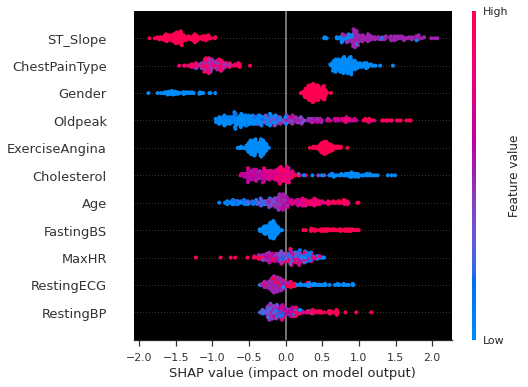

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [52]:
import matplotlib.pyplot as plt
with plt.rc_context({'axes.facecolor':'black'}):
    interpret_model(catboost)

# Model Interpretation

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=3892, verbose=0,
                       warm_start=False), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


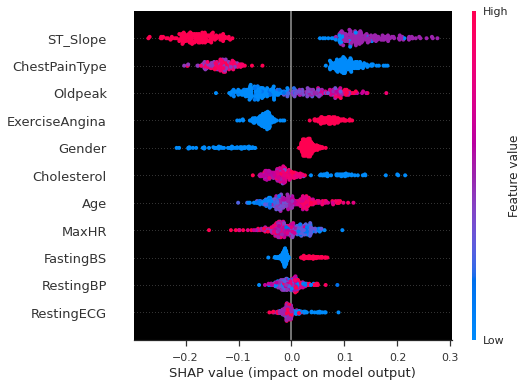

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [53]:
with plt.rc_context({'axes.facecolor':'black'}):
    interpret_model(rf)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=3892, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


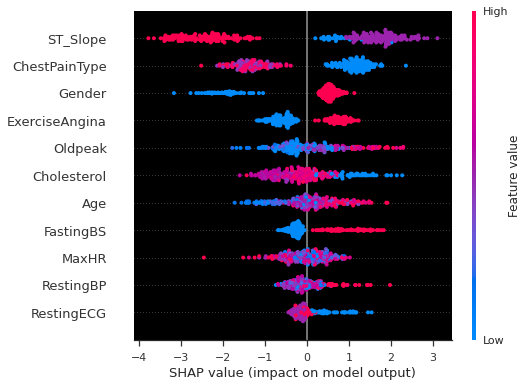

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [54]:
with plt.rc_context({'axes.facecolor':'black'}):
    interpret_model(lightgbm)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3892, splitter='best'), use_train_data=False, X_new_sample=None, y_new_sample=None, feature=None, kwargs={}, observation=None, plot=summary, save=False)
INFO:logs:Checking exceptions
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


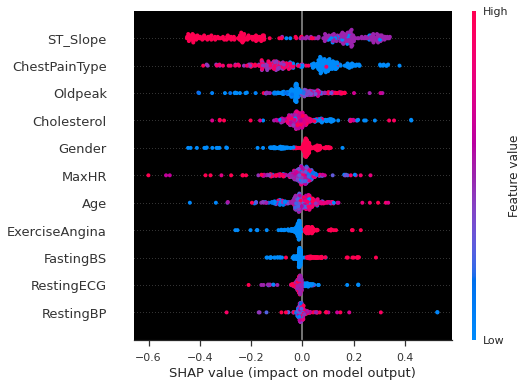

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [55]:
with plt.rc_context({'axes.facecolor':'black'}):
    interpret_model(dt)

# Hyperparameter Tuning

In [56]:
tuned_et = tune_model(et, optimize = 'Recall',verbose = False)
tuned_rf = tune_model(rf, optimize = 'Recall',verbose = False)
tuned_lightgbm = tune_model(lightgbm, optimize = 'Recall',verbose = False)
tuned_gbc = tune_model(gbc, optimize = 'Recall',verbose = False)
tuned_catboost = tune_model(catboost, optimize = 'Recall',verbose = False)
tuned_dt = tune_model(dt, optimize = 'auc',verbose = False)

INFO:logs:Initializing tune_model()
INFO:logs:tune_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3892, verbose=0,
                     warm_start=False), fold=None, round=4, n_iter=10, custom_grid=None, optimize=Recall, custom_scorer=None, search_library=scikit-learn, search_algorithm=None, early_stopping=False, early_stopping_max_iters=10, choose_better=False, fit_kwargs=None, groups=None, return_tuner=False, verbose=False, tuner_verbose=True, display=None, return_train_score=False, kwargs={})
INFO:logs:Checking exceptions
INFO:logs:Copying training

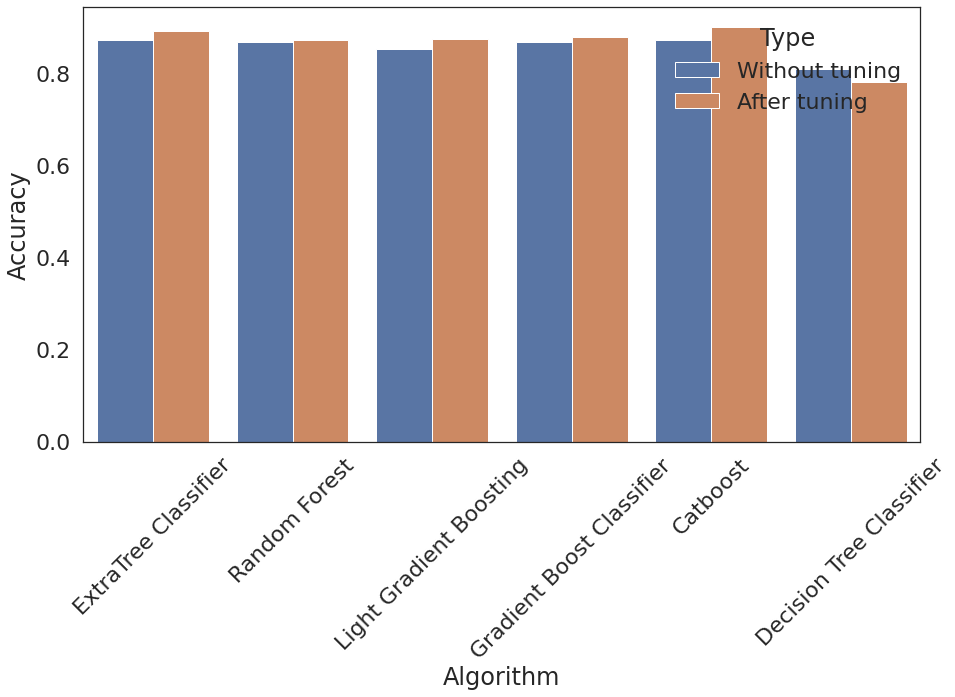

In [58]:
plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'Algorithm',
            y = 'Accuracy',
            hue = 'Type',
            data = df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
# Show the plot
plt.show()

# Stacking

In [ ]:
stack_model = stack_models(estimator_list = [et,rf,lightgbm,gbc,catboost], meta_model = catboost,optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8308,0.8924,0.8286,0.8529,0.8406,0.6603,0.6606
1,0.9538,0.9752,0.9429,0.9706,0.9565,0.9074,0.9078
2,0.9062,0.9480,0.9412,0.8889,0.9143,0.8110,0.8126
3,0.8750,0.9382,0.9118,0.8611,0.8857,0.7480,0.7495
4,0.8906,0.8966,0.9429,0.8684,0.9041,0.7773,0.7809
5,0.8594,0.9320,0.9429,0.8250,0.8800,0.7120,0.7213
6,0.8906,0.9005,0.9143,0.8889,0.9014,0.7787,0.7790
7,0.9062,0.9616,0.9429,0.8919,0.9167,0.8097,0.8113
8,0.7812,0.8916,0.8000,0.8000,0.8000,0.5586,0.5586


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 15
INFO:logs:StackingClassifier(cv=5,
                   estimators=[('et',
                                ExtraTreesClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                     

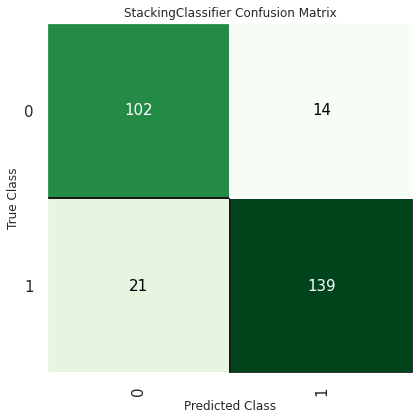

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
#Confusion matrix for stacked model
import seaborn as sns
sns.set(font_scale=1)
plt.figure(figsize=(6, 6))
plot_model(stack_model, plot='confusion_matrix')

# Soft Voting

In [ ]:
blend_soft = blend_models(estimator_list = [et,rf,lightgbm,gbc,catboost], optimize = 'Recall',method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.8914,0.8000,0.8235,0.8116,0.5986,0.5989
1,0.9231,0.9848,0.8857,0.9688,0.9254,0.8463,0.8500
2,0.8750,0.9529,0.9706,0.8250,0.8919,0.7460,0.7599
3,0.8438,0.9284,0.8824,0.8333,0.8571,0.6850,0.6864
4,0.8750,0.8926,0.9429,0.8462,0.8919,0.7448,0.7509
5,0.8594,0.9232,0.9143,0.8421,0.8767,0.7137,0.7170
6,0.8906,0.9064,0.9143,0.8889,0.9014,0.7787,0.7790
7,0.8906,0.9665,0.9429,0.8684,0.9041,0.7773,0.7809
8,0.8125,0.9074,0.8286,0.8286,0.8286,0.6217,0.6217


INFO:logs:create_model_container: 23
INFO:logs:master_model_container: 23
INFO:logs:display_container: 16
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2

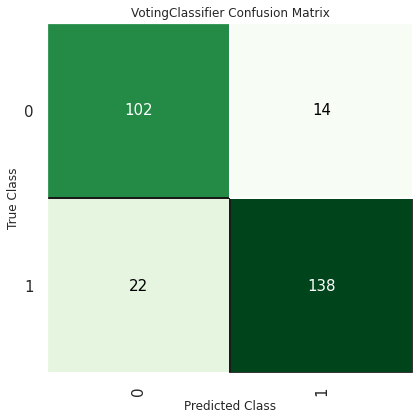

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plt.figure(figsize=(6, 6))
plot_model(blend_soft, plot='confusion_matrix')

# Hard Voting

In [ ]:
blend_hard = blend_models(estimator_list = [et,rf,lightgbm,gbc,catboost], optimize = 'Recall',method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.0,0.8000,0.8235,0.8116,0.5986,0.5989
1,0.9231,0.0,0.8857,0.9688,0.9254,0.8463,0.8500
2,0.8906,0.0,0.9412,0.8649,0.9014,0.7791,0.7826
3,0.8438,0.0,0.8824,0.8333,0.8571,0.6850,0.6864
4,0.9062,0.0,0.9429,0.8919,0.9167,0.8097,0.8113
5,0.8750,0.0,0.9429,0.8462,0.8919,0.7448,0.7509
6,0.9062,0.0,0.9429,0.8919,0.9167,0.8097,0.8113
7,0.8750,0.0,0.9143,0.8649,0.8889,0.7463,0.7478
8,0.7812,0.0,0.8000,0.8000,0.8000,0.5586,0.5586


INFO:logs:create_model_container: 24
INFO:logs:master_model_container: 24
INFO:logs:display_container: 17
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2

When judging the performance of the above three ensemble models by recall, the soft voting model has the best performance. Therefore, the soft voting model is selected as the final model and calibration is performed.

# Model Calibration

In [ ]:
cali_model = calibrate_model(blend_soft)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.8933,0.8000,0.8235,0.8116,0.5986,0.5989
1,0.9385,0.9781,0.9143,0.9697,0.9412,0.8768,0.8784
2,0.8750,0.9529,0.9412,0.8421,0.8889,0.7470,0.7531
3,0.8594,0.9353,0.9118,0.8378,0.8732,0.7160,0.7192
4,0.8906,0.8847,0.9429,0.8684,0.9041,0.7773,0.7809
5,0.8750,0.9222,0.9429,0.8462,0.8919,0.7448,0.7509
6,0.8750,0.9094,0.9143,0.8649,0.8889,0.7463,0.7478
7,0.8750,0.9665,0.9143,0.8649,0.8889,0.7463,0.7478
8,0.7969,0.8926,0.8000,0.8235,0.8116,0.5914,0.5916


INFO:logs:create_model_container: 25
INFO:logs:master_model_container: 25
INFO:logs:display_container: 18
INFO:logs:CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('et',
                                                                    ExtraTreesClassifier(bootstrap=False,
                                                                                         ccp_alpha=0.0,
                                                                                         class_weight=None,
                                                                                         criterion='gini',
                                                                                         max_depth=None,
                                                                                         max_features='auto',
                                                                                         max_leaf_nodes=None,
                                                            

The recall of the model completed until calibration is over 90%.

In [ ]:
final_model = finalize_model(cali_model)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('et',
                                                                    ExtraTreesClassifier(bootstrap=False,
                                                                                         ccp_alpha=0.0,
                                                                                         class_weight=None,
                                                                                         criterion='gini',
                                                                                         max_depth=None,
                                                                                         max_features='auto',
                                                                                         max_leaf_nodes=None,
                                                                                         max_samples=

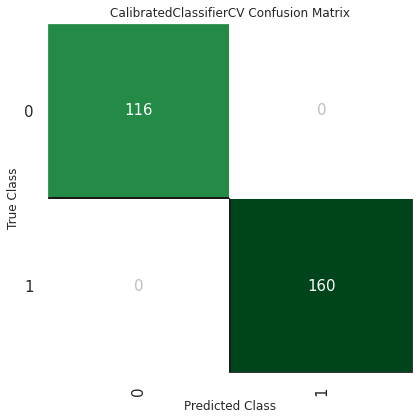

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plt.figure(figsize=(6, 6))
plot_model(final_model, plot='confusion_matrix')

Conclusion - Ensemble model with Soft Voting performs the best.